In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/tmnist-typeface-mnist/TMNIST_Data.csv


In [121]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Layer


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing 
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dense,InputLayer,Flatten,GlobalAveragePooling2D, Input,Conv2D,Resizing
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [113]:
train_data0 = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
train_data1 = pd.read_csv("/kaggle/input/tmnist-typeface-mnist/TMNIST_Data.csv")

train_X0 = train_data0.iloc[:, 1:].values
train_y0 = train_data0.iloc[:, 0].values

train_X1 = train_data1.iloc[:, 2:].values
train_y1 = train_data1.iloc[:, 1].values


train_X = np.vstack((train_X0, train_X1))
train_y = np.hstack((train_y0, train_y1))

train_X = train_X/255.00 # normalize pixels

In [114]:
def invert_colors(image):
    return 1.0 - image


train_X = train_X.reshape(-1,28,28,1)

x_train_inverted = invert_colors(train_X)

train_X = np.vstack((train_X, x_train_inverted))
train_y = np.hstack((train_y, train_y))

In [115]:
train_X, test_X, train_y, test_y = train_test_split(train_X, train_y, test_size=0.2, random_state=42)


In [117]:
test_X = test_X.reshape(-1,28,28,1)

In [93]:
train_X.shape

(115040, 28, 28, 1)

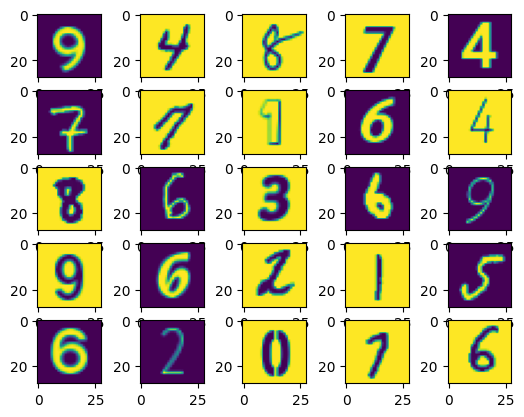

In [118]:
import math
from random import randint

f ,ax = plt.subplots(5,5)

for i in range(25):
    img = train_X[randint(0, train_X.shape[0]-1)]  # Select a random image
    ax[i//5, i%5].imshow(img)  # Display the image in the grid
#     ax[i//5, i%5].axis('off')  # Hide the axis
    

In [94]:
datagen = ImageDataGenerator(
    rotation_range=180,          # Rotate images within 180 degrees
    width_shift_range=0.2,      # Shift images horizontally by 10% of the width
    height_shift_range=0.2,     # Shift images vertically by 10% of the height
    zoom_range=0.2,             # Zoom in images by 10%
    horizontal_flip=True,       # Randomly flip images horizontally
    vertical_flip=False,        # Randomly flip images vertically
    brightness_range=[0.8, 1.2],# Adjust brightness
    shear_range=50,
)

# datagen.fit(train_X)

In [130]:
# Load the VGG16 model pre-trained on ImageNet, without the top (classification) layer
base_model =  VGG16(input_shape=(32, 32, 3), weights='imagenet', include_top=False)
base_model.trainable = False

# Print the model summary to see its architecture
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [131]:
class GrayscaleToRGB(Layer):
    def __init__(self, **kwargs):
        super(GrayscaleToRGB, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.image.grayscale_to_rgb(inputs)

In [132]:
model = Sequential([
    InputLayer(input_shape=(28, 28, 1)),
    Resizing(32, 32),
    GrayscaleToRGB(),
    base_model,
    Flatten(),
    Dense(10, activation='softmax'),
]
)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [133]:
earlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy',
    min_delta=0.01,
    patience=2,
    restore_best_weights=True,
)


In [134]:
test_X, val_X, test_y, val_y = train_test_split(test_X, test_y, test_size=0.2, random_state=42)


In [102]:
test_y.shape

(23008,)

In [135]:
history = model.fit(
    train_X, 
    train_y,
    epochs=10,
    batch_size=512,
    validation_split=0.1,
#     validation_data=(val_X, val_y),
    callbacks=earlyStopping
)


Epoch 1/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 568s 3s/step - accuracy: 0.5297 - loss: 1.7142 - val_accuracy: 0.8061 - val_loss: 0.8876
Epoch 2/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 565s 3s/step - accuracy: 0.8211 - loss: 0.7994 - val_accuracy: 0.8500 - val_loss: 0.6302
Epoch 3/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 563s 3s/step - accuracy: 0.8627 - loss: 0.5954 - val_accuracy: 0.8747 - val_loss: 0.5148
Epoch 4/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 564s 3s/step - accuracy: 0.8829 - loss: 0.4904 - val_accuracy: 0.8915 - val_loss: 0.4452
Epoch 5/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 564s 3s/step - accuracy: 0.8962 - loss: 0.4272 - val_accuracy: 0.9013 - val_loss: 0.3972
Epoch 6/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 565s 3s/step - accuracy: 0.9076 - loss: 0.3788 - val_accuracy: 0.9072 - val_loss: 0.3631
Epoch 7/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 564s 3s/step - accuracy: 0.9147 - loss: 0.3440 - val_accuracy: 0.9117 - val_loss: 0.3373
Epoch 8/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 622s 3s/step - accuracy: 0.9190 - loss: 0.3188 - val_accu

In [136]:
model.save('/kaggle/working/model.h5')

In [138]:
test_loss, test_acc = model.evaluate(test_X, test_y)
# y_pred = model.predict(test_X,test_y)

576/576 ━━━━━━━━━━━━━━━━━━━━ 92s 160ms/step - accuracy: 0.9173 - loss: 0.3250


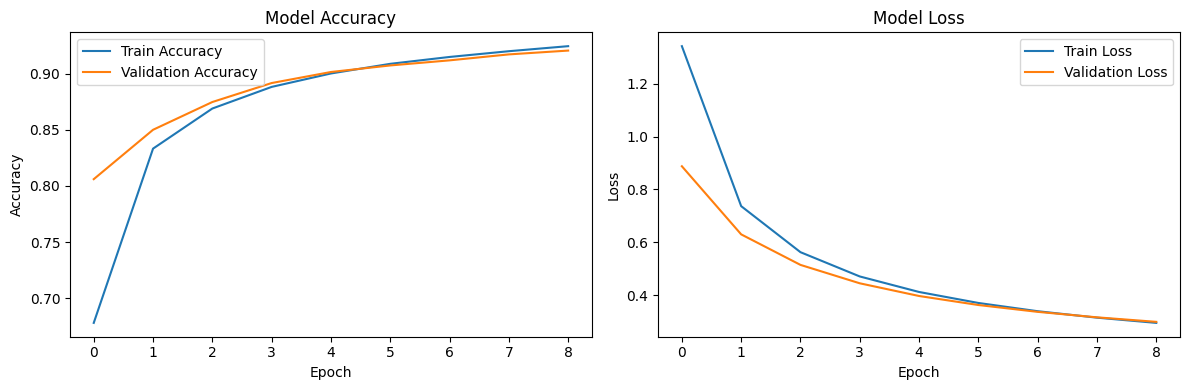

In [141]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
